# Creating a Simple Image Processing App with MONAI Deploy App SDK

This tutorial shows how a simple image processing application can be created with MONAI Deploy App SDK.


## Creating Operators and connecting them in Application class

We will implement an application that consists of three Operators:

- **SobelOperator**: Apply a Sobel edge detector.
    - **Input**: a file path (`Path`)
    - **Output**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
- **MedianOperator**: Apply a Median filter for noise reduction.
    - **Input**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
    - **Output**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
- **GaussianOperator**: Apply a Gaussian filter for smoothening.
    - **Input**: an image object in memory ([`Image`](/modules/_autosummary/monai.deploy.core.domain.Image))
    - **Output**: a file path (`Path`)

The workflow of the application would look like this.

```{mermaid}
%%{init: {"theme": "base", "themeVariables": { "fontSize": "16px"}} }%%

classDiagram
    direction LR

    SobelOperator --|> MedianOperator : image...image
    MedianOperator --|> GaussianOperator : image...image

    class SobelOperator {
        <in>image : Path
        image(out) : IN_MEMORY
    }
    class MedianOperator {
        <in>image : IN_MEMORY
        image(out) : IN_MEMORY
    }
    class GaussianOperator {
        <in>image : IN_MEMORY
        image(out) : Path
    }
```

### Setup environment


In [1]:
# Install necessary image loading/processing packages for the application
!python -c "import PIL" || pip install -q "Pillow"
!python -c "import skimage" || pip install -q "scikit-image"
!python -c "import matplotlib" || pip install -q "matplotlib"
%matplotlib inline

# Install MONAI Deploy App SDK package
!python -c "import monai.deploy" || pip install -q "monai-deploy-app-sdk"

### Download test input

We will use a test input from the following.

> Case courtesy of Dr Bruno Di Muzio, <a href="https://radiopaedia.org/?lang=us">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/41113?lang=us">rID: 41113</a>

Test input file path: '/tmp/simple_app/normal-brain-mri-4.png'


/tmp/ipykernel_58609/2727006292.py:16: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(test_image)


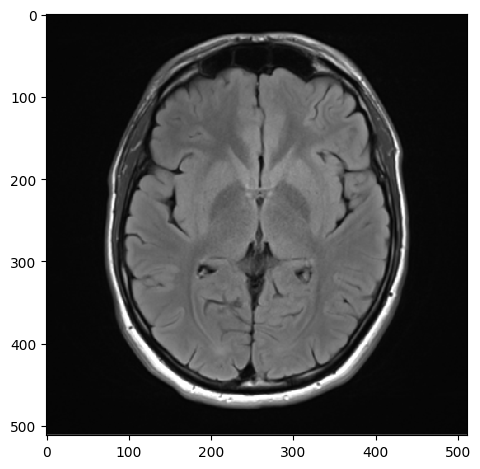

In [2]:
test_input_folder = "/tmp/simple_app"
test_input_path = test_input_folder + "/normal-brain-mri-4.png"

!python -c "import wget" || pip install -q "wget"
!mkdir -p {test_input_folder}

from skimage import io
import wget


wget.download("https://user-images.githubusercontent.com/1928522/133383228-2357d62d-316c-46ad-af8a-359b56f25c87.png", test_input_path)

print(f"Test input file path: {test_input_path!r}")

test_image = io.imread(test_input_path)
io.imshow(test_image)

### Set up environment variables
The application uses well-known environment variables for the input/output data path, working dir, as well as AI model file path if applicable. Defaults are used if these environment variable are absent.

In this example, only the input data path and output path need to be set.

In [3]:
output_path = "output"
%env HOLOSCAN_INPUT_FOLDER {test_input_folder}
%env HOLOSCAN_INPUT_PATH {test_input_path}
%env HOLOSCAN_OUTPUT_PATH {output_path}
%ls $HOLOSCAN_INPUT_PATH

env: HOLOSCAN_INPUT_FOLDER=/tmp/simple_app
env: HOLOSCAN_INPUT_PATH=/tmp/simple_app/normal-brain-mri-4.png
env: HOLOSCAN_OUTPUT_PATH=output
/tmp/simple_app/normal-brain-mri-4.png


### Setup imports

Let's import necessary classes/decorators to define the application and operators.

In [4]:
from pathlib import Path

from monai.deploy.conditions import CountCondition
from monai.deploy.core import AppContext, Application, ConditionType, Fragment, Operator, OperatorSpec

### Creating Operator classes

Each Operator class inherits from the [Operator](/modules/_autosummary/monai.deploy.core.Operator) class, with the input and output ports of the operator specified using the `setup` method. Business logic would be implemented in the <a href="../../modules/_autosummary/monai.deploy.core.Operator.html#monai.deploy.core.Operator.compute">compute</a> method.

:::{note}
- the way to specify operator input and output in this version of the App SDK is different from versions, up to and including V0.5, where Python decorators are used. Decorator support will be re-introduced in future releases
- the first operator(SobelOperator)'s input and the last operator(GaussianOperator)'s output are data paths, which are not data types supported by operator ports but as object can be used as optional input and output. In the example, these paths are passed in as arguments to the constructor and the operator classes have defined logic on using the paths, e.g. reading from or writing to the path. The application class is responsible for setting the path by parsing the well-known environment variables
:::

#### SobelOperator

SobelOperator is the first operator (the root operator in the workflow graph). It reads from the input file/folder path, which is passed in as an argument on the constructor and assigned to an attribute.

Once loaded and processed, the image data (as a Numpy array) is set to the output (<a href="../../modules/_autosummary/monai.deploy.core.OutputContext.html#monai.deploy.core.OutputContext.emit">op_output.emit(value, label)</a>).

In [5]:
class SobelOperator(Operator):
    """This Operator implements a Sobel edge detector.

    It has the following input and output:
        single input:
          a image file, first one found in the input folder
        single output:
          array object in memory
    """

    DEFAULT_INPUT_FOLDER = Path.cwd() / "input"

    def __init__(self, fragment: Fragment, *args, input_path: Path, **kwargs):
        """Create an instance to be part of the given application (fragment).

        Args:
            fragment (Fragment): An instance of the Application class which is derived from Fragment
            input_path (Path): The path of the input image file or folder containing the image file
        """
        self.index = 0

        # May want to validate the path, but it should really be validated when the compute function is called, also,
        # when file path as input is supported in the operator or execution context, input_folder needs not an attribute.
        self.input_path = (
            input_path if input_path else SobelOperator.DEFAULT_INPUT_FOLDER
        )

        # Need to call the base class constructor last
        super().__init__(fragment, *args, **kwargs)

    def setup(self, spec: OperatorSpec):
        spec.output("out1")

    def compute(self, op_input, op_output, context):
        from skimage import filters, io

        self.index += 1
        print(f"Number of times operator {self.name} whose class is defined in {__name__} called: {self.index}")

        # Ideally the op_input or execution context should provide the file path
        # to read data from, for operators that are file input based.
        # For now, use a temporary way to get input path. e.g. value set on init
        input_path = self.input_path
        print(f"Input from: {input_path}, whose absolute path: {input_path.absolute()}")
        if input_path.is_dir():
            input_path = next(input_path.glob("*.*"))  # take the first file

        data_in = io.imread(input_path)[:, :, :3]  # discard alpha channel if exists
        data_out = filters.sobel(data_in)

        op_output.emit(data_out, "out1")

#### MedianOperator

MedianOperator is a middle operator that accepts data from SobelOperator and passes the processed image data to GaussianOperator.

Its input data type is image in Numpy array. Once received at the input (`op_input.receive(label)`), the image is transformed and set to the output (`op_output.emit(value, label)`).

In [6]:
class MedianOperator(Operator):
    """This Operator implements a noise reduction.

    The algorithm is based on the median operator.
    It ingests a single input and provides a single output, both are in-memory image arrays
    """

    # Define __init__ method with super().__init__() if you want to override the default behavior.
    def __init__(self, fragment: Fragment, *args, **kwargs):
        """Create an instance to be part of the given application (fragment).

        Args:
            fragment (Fragment): The instance of Application class which is derived from Fragment
        """

        self.index = 0

        # Need to call the base class constructor last
        super().__init__(fragment, *args, **kwargs)

    def setup(self, spec: OperatorSpec):
        spec.input("in1")
        spec.output("out1")

    def compute(self, op_input, op_output, context):
        from skimage.filters import median

        self.index += 1
        print(f"Number of times operator {self.name} whose class is defined in {__name__} called: {self.index}")
        data_in = op_input.receive("in1")
        data_out = median(data_in)
        op_output.emit(data_out, "out1")

#### GaussianOperator

GaussianOperator is the last operator (a leaf operator in the workflow graph) and saves the processed image to a file, whose path is provided via an argument on the constructor.

This operator can also output the image in Numpy array in memory without requiring a receiver for it. This can be set up by using the optional output condition in the function `setup`.

In [7]:
class GaussianOperator(Operator):
    """This Operator implements a smoothening based on Gaussian.

    It has the following input and output:
        single input:
          an image array object
        single output:
          an image array object, without enforcing a downstream receiver

    Besides, this operator also saves the image file in the given output folder.
    """

    DEFAULT_OUTPUT_FOLDER = Path.cwd() / "output"

    def __init__(self, fragment: Fragment, *args, output_folder: Path, **kwargs):
        """Create an instance to be part of the given application (fragment).

        Args:
            fragment (Fragment): The instance of Application class which is derived from Fragment
            output_folder (Path): The folder to save the output file.
        """
        self.output_folder = output_folder if output_folder else GaussianOperator.DEFAULT_OUTPUT_FOLDER
        self.index = 0

        # If `self.sigma_default` is set here (e.g., `self.sigma_default = 0.2`), then
        # the default value by `param()` in `setup()` will be ignored.
        # (you can just call `spec.param("sigma_default")` in `setup()` to use the
        # default value)
        self.sigma_default = 0.2
        self.channel_axis = 2

        # Need to call the base class constructor last
        super().__init__(fragment, *args, **kwargs)

    def setup(self, spec: OperatorSpec):
        spec.input("in1")
        spec.output("out1").condition(ConditionType.NONE)  # Condition is for no or not-ready receiver ports.
        spec.param("sigma_default", 0.2)
        spec.param("channel_axis", 2)

    def compute(self, op_input, op_output, context):
        from skimage.filters import gaussian
        from skimage.io import imsave
        import numpy as np

        self.index += 1
        print(f"Number of times operator {self.name} whose class is defined in {__name__} called: {self.index}")

        data_in = op_input.receive("in1")
        data_out = gaussian(data_in, sigma=self.sigma_default, channel_axis=self.channel_axis)

        # Make sure the data type is what PIL Image can support, as the imsave function calls PIL Image fromarray()
        # Some details can be found at https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
        print(f"Data type of output: {type(data_out)!r}, max = {np.max(data_out)!r}")
        if np.max(data_out) <= 1:
            data_out = (data_out*255).astype(np.uint8)
        print(f"Data type of output post conversion: {type(data_out)!r}, max = {np.max(data_out)!r}")

        # For now, use attribute of self to find the output path.
        self.output_folder.mkdir(parents=True, exist_ok=True)
        output_path = self.output_folder / "final_output.png"
        imsave(output_path, data_out)

        op_output.emit(data_out, "out1")


### Creating Application class

Our application class would look like below.

It defines `App` class, inheriting [Application](/modules/_autosummary/monai.deploy.core.Application) class.

In `compose()` method, objects of `SobelOperator`, `MedianOperator`, and `GaussianOperator` classes are created
and connected through <a href="../../modules/_autosummary/monai.deploy.core.Application.html#monai.deploy.core.Application.add_flow">self.add_flow()</a>.

> add_flow(source_op, destination_op, io_map=None)

`io_map` is a dictionary of mapping from the source operator's label to the destination operator's label(s) and its type is `Set[Tuple[str, str]]`.

We can skip specifying `io_map` if both the number of `source_op`'s outputs and the number of `destination_op`'s inputs are one so `self.add_flow(sobel_op, median_op)` is same with `self.add_flow(sobel_op, median_op, {"image": "image"})` or `self.add_flow(sobel_op, median_op, {"image": {"image"}})`.

In [8]:
class App(Application):
    """This is a very basic application.

    This showcases the MONAI Deploy application framework.
    """

    # App's name. <class name>('App') if not specified.
    name = "simple_imaging_app"
    # App's description. <class docstring> if not specified.
    description = "This is a very simple application."
    # App's version. <git version tag> or '0.0.0' if not specified.
    version = "0.1.0"

    def compose(self):
        """This application has three operators.

        Each operator has a single input and a single output port.
        Each operator performs some kind of image processing function.
        """
        app_context = Application.init_app_context({})  # Do not pass argv in Jupyter notebook
        sample_data_path = Path(app_context.input_path)
        output_data_path = Path(app_context.output_path)
        print(f"sample_data_path: {sample_data_path}")

        # Please note that the Application object, self, is passed as the first positional argument
        # and the others as kwargs.
        # Also note the CountCondition of 1 on the first operator, indicating to the application executor
        # to invoke this operator, hence the pipeline, only once.
        sobel_op = SobelOperator(self, CountCondition(self, 1), input_path=sample_data_path, name="sobel_op")
        median_op = MedianOperator(self, name="median_op")
        gaussian_op = GaussianOperator(self, output_folder=output_data_path, name="gaussian_op")
        self.add_flow(
            sobel_op,
            median_op,
            {
                ("out1", "in1"),
            },
        )
        self.add_flow(
            median_op,
            gaussian_op,
            {
                (
                    "out1",
                    "in1",
                )
            },
        )  # Using port name is optional for single port cases


if __name__ == "__main__":
    print("The statement, App().run(), is needed when this is run directly by the interpreter.")
    # App().run()

The statement, App().run(), is needed when this is run directly by the interpreter.


## Executing app locally

We can execute the app in the Jupyter notebook.

In [9]:
!rm -rf {output_path}
App().run()

[info] [fragment.cpp:599] Loading extensions from configs...
[2025-01-29 12:08:18,760] [INFO] (root) - Parsed args: Namespace(log_level=None, input=None, output=None, model=None, workdir=None, argv=[])
[2025-01-29 12:08:18,775] [INFO] (root) - AppContext object: AppContext(input_path=/tmp/simple_app/normal-brain-mri-4.png, output_path=output, model_path=models, workdir=)


sample_data_path: /tmp/simple_app/normal-brain-mri-4.png
Number of times operator sobel_op whose class is defined in __main__ called: 1
Input from: /tmp/simple_app/normal-brain-mri-4.png, whose absolute path: /tmp/simple_app/normal-brain-mri-4.png


[info] [gxf_executor.cpp:264] Creating context
[info] [gxf_executor.cpp:1797] creating input IOSpec named 'in1'
[info] [gxf_executor.cpp:1797] creating input IOSpec named 'in1'
[info] [gxf_executor.cpp:2208] Activating Graph...
[info] [gxf_executor.cpp:2238] Running Graph...
[info] [gxf_executor.cpp:2240] Waiting for completion...
[info] [greedy_scheduler.cpp:191] Scheduling 3 entities


Number of times operator median_op whose class is defined in __main__ called: 1
Number of times operator gaussian_op whose class is defined in __main__ called: 1
Data type of output: <class 'numpy.ndarray'>, max = 0.35821119421406195
Data type of output post conversion: <class 'numpy.ndarray'>, max = 91


[info] [greedy_scheduler.cpp:372] Scheduler stopped: Some entities are waiting for execution, but there are no periodic or async entities to get out of the deadlock.
[info] [greedy_scheduler.cpp:401] Scheduler finished.
[info] [gxf_executor.cpp:2243] Deactivating Graph...
[info] [gxf_executor.cpp:2251] Graph execution finished.
[info] [gxf_executor.cpp:294] Destroying context


In [10]:
!ls {output_path}

final_output.png


/tmp/ipykernel_58609/1643627018.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(output_image)


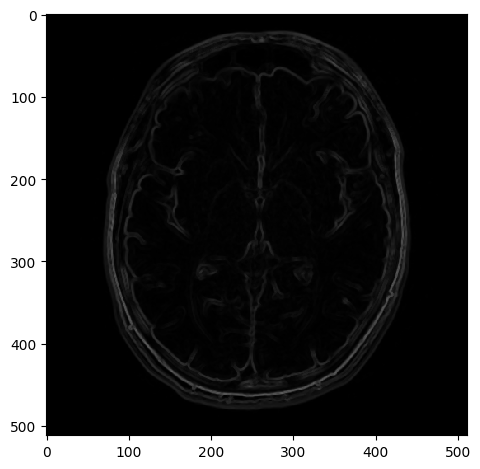

In [11]:
output_image_path = output_path + "/final_output.png"
output_image = io.imread(output_image_path)
io.imshow(output_image)

Once the application is verified inside Jupyter notebook, we can write the above Python code into Python files in an application folder.

The application folder structure would look like below:

```bash
simple_imaging_app
├── __main__.py
├── app.py
├── gaussian_operator.py
├── median_operator.py
└── sobel_operator.py
```

:::{note}
We can create a single application Python file (such as `simple_imaging_app.py`) that includes the content of the files, instead of creating multiple files.
You will see such example in <a href="./02_mednist_app.html#executing-app-locally">MedNist Classifier Tutorial</a>.
:::

In [12]:
# Create an application folder
!mkdir -p simple_imaging_app

### sobel_operator.py

In [13]:
%%writefile simple_imaging_app/sobel_operator.py

from pathlib import Path
from monai.deploy.core import Fragment, Operator, OperatorSpec

class SobelOperator(Operator):
    """This Operator implements a Sobel edge detector.

    It has the following input and output:
        single input:
          a image file, first one found in the input folder
        single output:
          array object in memory
    """

    DEFAULT_INPUT_FOLDER = Path.cwd() / "input"

    def __init__(self, fragment: Fragment, *args, input_path: Path, **kwargs):
        """Create an instance to be part of the given application (fragment).

        Args:
            fragment (Fragment): An instance of the Application class which is derived from Fragment
            input_path (Path): The path of the input image file or folder containing the image file
        """
        self.index = 0

        # May want to validate the path, but it should really be validated when the compute function is called, also,
        # when file path as input is supported in the operator or execution context, input_folder needs not an attribute.
        self.input_path = (
            input_path if input_path else SobelOperator.DEFAULT_INPUT_FOLDER
        )

        # Need to call the base class constructor last
        super().__init__(fragment, *args, **kwargs)

    def setup(self, spec: OperatorSpec):
        spec.output("out1")

    def compute(self, op_input, op_output, context):
        from skimage import filters, io

        self.index += 1
        print(f"Number of times operator {self.name} whose class is defined in {__name__} called: {self.index}")

        # Ideally the op_input or execution context should provide the file path
        # to read data from, for operators that are file input based.
        # For now, use a temporary way to get input path. e.g. value set on init
        input_path = self.input_path
        print(f"Input from: {input_path}, whose absolute path: {input_path.absolute()}")
        if input_path.is_dir():
            input_path = next(input_path.glob("*.*"))  # take the first file

        data_in = io.imread(input_path)[:, :, :3]  # discard alpha channel if exists
        data_out = filters.sobel(data_in)

        op_output.emit(data_out, "out1")

Writing simple_imaging_app/sobel_operator.py


### median_operator.py

In [14]:
%%writefile simple_imaging_app/median_operator.py
from monai.deploy.core import Fragment, Operator, OperatorSpec


# Decorator support is not available in this version of the SDK, to be re-introduced later
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class MedianOperator(Operator):
    """This Operator implements a noise reduction.

    The algorithm is based on the median operator.
    It ingests a single input and provides a single output, both are in-memory image arrays
    """

    # Define __init__ method with super().__init__() if you want to override the default behavior.
    def __init__(self, fragment: Fragment, *args, **kwargs):
        """Create an instance to be part of the given application (fragment).

        Args:
            fragment (Fragment): The instance of Application class which is derived from Fragment
        """

        self.index = 0

        # Need to call the base class constructor last
        super().__init__(fragment, *args, **kwargs)

    def setup(self, spec: OperatorSpec):
        spec.input("in1")
        spec.output("out1")

    def compute(self, op_input, op_output, context):
        from skimage.filters import median

        self.index += 1
        print(f"Number of times operator {self.name} whose class is defined in {__name__} called: {self.index}")
        data_in = op_input.receive("in1")
        data_out = median(data_in)
        op_output.emit(data_out, "out1")


Writing simple_imaging_app/median_operator.py


### gaussian_operator.py

In [15]:
%%writefile simple_imaging_app/gaussian_operator.py
from pathlib import Path

from monai.deploy.core import ConditionType, Fragment, Operator, OperatorSpec


# Decorator support is not available in this version of the SDK, to be re-introduced later
# @md.env(pip_packages=["scikit-image >= 0.17.2"])
class GaussianOperator(Operator):
    """This Operator implements a smoothening based on Gaussian.

    It has the following input and output:
        single input:
          an image array object
        single output:
          an image array object, without enforcing a downstream receiver

    Besides, this operator also saves the image file in the given output folder.
    """

    DEFAULT_OUTPUT_FOLDER = Path.cwd() / "output"

    def __init__(self, fragment: Fragment, *args, output_folder: Path, **kwargs):
        """Create an instance to be part of the given application (fragment).

        Args:
            fragment (Fragment): The instance of Application class which is derived from Fragment
            output_folder (Path): The folder to save the output file.
        """
        self.output_folder = output_folder if output_folder else GaussianOperator.DEFAULT_OUTPUT_FOLDER
        self.index = 0

        # If `self.sigma_default` is set here (e.g., `self.sigma_default = 0.2`), then
        # the default value by `param()` in `setup()` will be ignored.
        # (you can just call `spec.param("sigma_default")` in `setup()` to use the
        # default value)
        self.sigma_default = 0.2
        self.channel_axis = 2

        # Need to call the base class constructor last
        super().__init__(fragment, *args, **kwargs)

    def setup(self, spec: OperatorSpec):
        spec.input("in1")
        spec.output("out1").condition(ConditionType.NONE)  # Condition is for no or not-ready receiver ports.
        spec.param("sigma_default", 0.2)
        spec.param("channel_axis", 2)

    def compute(self, op_input, op_output, context):
        from skimage.filters import gaussian
        from skimage.io import imsave
        import numpy as np

        self.index += 1
        print(f"Number of times operator {self.name} whose class is defined in {__name__} called: {self.index}")

        data_in = op_input.receive("in1")
        data_out = gaussian(data_in, sigma=self.sigma_default, channel_axis=self.channel_axis)

        # Make sure the data type is what PIL Image can support, as the imsave function calls PIL Image fromarray()
        # Some details can be found at https://stackoverflow.com/questions/55319949/pil-typeerror-cannot-handle-this-data-type
        print(f"Data type of output: {type(data_out)!r}, max = {np.max(data_out)!r}")
        if np.max(data_out) <= 1:
            data_out = (data_out*255).astype(np.uint8)
        print(f"Data type of output post conversion: {type(data_out)!r}, max = {np.max(data_out)!r}")

        # For now, use attribute of self to find the output path.
        self.output_folder.mkdir(parents=True, exist_ok=True)
        output_path = self.output_folder / "final_output.png"
        imsave(output_path, data_out)

        op_output.emit(data_out, "out1")


Writing simple_imaging_app/gaussian_operator.py


### app.py

In [16]:
%%writefile simple_imaging_app/app.py
import logging
from pathlib import Path

from gaussian_operator import GaussianOperator
from median_operator import MedianOperator
from sobel_operator import SobelOperator

from monai.deploy.conditions import CountCondition
from monai.deploy.core import AppContext, Application


# Decorator support is not available in this version of the SDK, to be re-introduced later
# @resource(cpu=1)
class App(Application):
    """This is a very basic application.

    This showcases the MONAI Deploy application framework.
    """

    # App's name. <class name>('App') if not specified.
    name = "simple_imaging_app"
    # App's description. <class docstring> if not specified.
    description = "This is a very simple application."
    # App's version. <git version tag> or '0.0.0' if not specified.
    version = "0.1.0"

    def compose(self):
        """This application has three operators.

        Each operator has a single input and a single output port.
        Each operator performs some kind of image processing function.
        """
        # Use Commandline options over environment variables to init context.
        app_context = Application.init_app_context(self.argv)
        sample_data_path = Path(app_context.input_path)
        output_data_path = Path(app_context.output_path)
        logging.info(f"sample_data_path: {sample_data_path}")

        # Please note that the Application object, self, is passed as the first positional argument
        # and the others as kwargs.
        # Also note the CountCondition of 1 on the first operator, indicating to the application executor
        # to invoke this operator, hence the pipeline, only once.
        sobel_op = SobelOperator(self, CountCondition(self, 1), input_path=sample_data_path, name="sobel_op")
        median_op = MedianOperator(self, name="median_op")
        gaussian_op = GaussianOperator(self, output_folder=output_data_path, name="gaussian_op")
        self.add_flow(
            sobel_op,
            median_op,
            {
                ("out1", "in1"),
            },
        )
        self.add_flow(
            median_op,
            gaussian_op,
            {
                (
                    "out1",
                    "in1",
                )
            },
        )


if __name__ == "__main__":
    logging.info(f"Begin {__name__}")
    App().run()
    logging.info(f"End {__name__}")


Writing simple_imaging_app/app.py


```python
if __name__ == "__main__":
    App().run()
```

The above lines are needed to execute the application code by using `python` interpreter.

### \_\_main\_\_.py

\_\_main\_\_.py is needed for <a href="../../developing_with_sdk/packaging_app.html">MONAI Application Packager</a> to detect the main application code (`app.py`) when the application is executed with the application folder path (e.g., `python simple_imaging_app`).

In [17]:
%%writefile simple_imaging_app/__main__.py
from app import App

if __name__ == "__main__":
    App().run()

Writing simple_imaging_app/__main__.py


In [18]:
!ls simple_imaging_app

app.py		      __main__.py	  sobel_operator.py
gaussian_operator.py  median_operator.py


This time, let's execute the app in the command line.

:::{note}
Since the environment variables have been set and contain the correct paths, it is not necessary to provide the command line options on running the application, though the following demonstrates the use of the options.
:::

In [19]:
!rm -rf {output_path}
!python simple_imaging_app -i {test_input_folder} -o {output_path} -l DEBUG

[info] [fragment.cpp:599] Loading extensions from configs...
[2025-01-29 12:08:26,105] [INFO] (root) - Parsed args: Namespace(log_level='DEBUG', input=PosixPath('/tmp/simple_app'), output=PosixPath('/home/mqin/src/monai-deploy-app-sdk/notebooks/tutorials/output'), model=None, workdir=None, argv=['simple_imaging_app', '-i', '/tmp/simple_app', '-o', 'output', '-l', 'DEBUG'])
[2025-01-29 12:08:26,111] [INFO] (root) - AppContext object: AppContext(input_path=/tmp/simple_app, output_path=/home/mqin/src/monai-deploy-app-sdk/notebooks/tutorials/output, model_path=models, workdir=)
[2025-01-29 12:08:26,111] [INFO] (root) - sample_data_path: /tmp/simple_app
[info] [gxf_executor.cpp:264] Creating context
[info] [gxf_executor.cpp:1797] creating input IOSpec named 'in1'
[info] [gxf_executor.cpp:1797] creating input IOSpec named 'in1'
[info] [gxf_executor.cpp:2208] Activating Graph...
[info] [gxf_executor.cpp:2238] Running Graph...
[info] [gxf_executor.cpp:2240] Waiting for completion...
[info] [gr

/tmp/ipykernel_58609/3197869135.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(output_image)


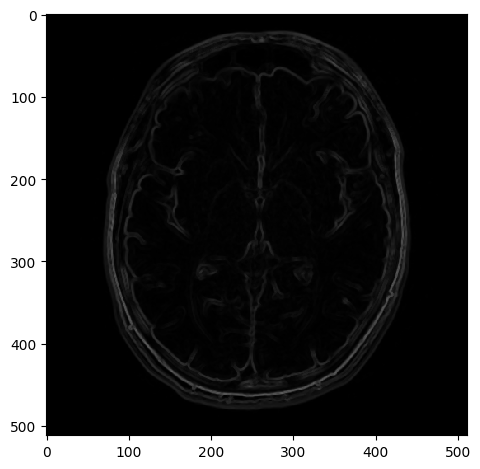

In [20]:
#output_image_path was set as before, output_image_path = output_path + "/final_output.png"
output_image = io.imread(output_image_path)
io.imshow(output_image)

## Packaging app

Let's package the app with <a href="../../developing_with_sdk/packaging_app.html">MONAI Application Packager</a>.

In this version of the App SDK, we need to write out the configuration yaml file as well as the package requirements file, in the application folder.

In [21]:
%%writefile simple_imaging_app/app.yaml
%YAML 1.2
---
application:
  title: MONAI Deploy App Package - Simple Imaging App
  version: 1.0
  inputFormats: ["file"]
  outputFormats: ["file"]

resources:
  cpu: 1
  gpu: 1
  memory: 1Gi
  gpuMemory: 1Gi

Writing simple_imaging_app/app.yaml


In [22]:
%%writefile simple_imaging_app/requirements.txt
scikit-image
setuptools>=59.5.0 # for pkg_resources
holoscan>=2.9.0  # avoid v2.7 and v2.8 for a known issue


Writing simple_imaging_app/requirements.txt


Now we can use the CLI package command to build the MONAI Application Package (MAP) container image based on a supported base image.

In [23]:
tag_prefix = "simple_imaging_app"

!monai-deploy package simple_imaging_app -c simple_imaging_app/app.yaml -t {tag_prefix}:1.0 --platform x64-workstation -l DEBUG

[2025-01-29 12:08:28,758] [INFO] (common) - Downloading CLI manifest file...
[2025-01-29 12:08:29,206] [DEBUG] (common) - Validating CLI manifest file...
[2025-01-29 12:08:29,206] [INFO] (packager.parameters) - Application: /home/mqin/src/monai-deploy-app-sdk/notebooks/tutorials/simple_imaging_app
[2025-01-29 12:08:29,207] [INFO] (packager.parameters) - Detected application type: Python Module
[2025-01-29 12:08:29,207] [INFO] (packager) - Reading application configuration from /home/mqin/src/monai-deploy-app-sdk/notebooks/tutorials/simple_imaging_app/app.yaml...
[2025-01-29 12:08:29,212] [INFO] (packager) - Generating app.json...
[2025-01-29 12:08:29,213] [INFO] (packager) - Generating pkg.json...
[2025-01-29 12:08:29,217] [DEBUG] (common) - 
=============== Begin app.json ===============
{
    "apiVersion": "1.0.0",
    "command": "[\"python3\", \"/opt/holoscan/app\"]",
    "environment": {
        "HOLOSCAN_APPLICATION": "/opt/holoscan/app",
        "HOLOSCAN_INPUT_PATH": "input/",
 

:::{note}
Building a MONAI Application Package (Docker image) can take time. Use `-l DEBUG` option if you want to see the progress.

:::

We can see that the MAP Docker image is created.

In [24]:
!docker image ls | grep {tag_prefix}

simple_imaging_app-x64-workstation-dgpu-linux-amd64                           1.0                            a00c56131135   55 seconds ago   2.98GB


We can choose to display and inspect the MAP manifests by running the container with the `show` command.
Furthermore, we can also extract the manifests and other contents in the MAP by using the `extract` command while mapping specific folder to the host's (we know that our MAP is compliant and supports these commands).

:::{note}
The host folder for storing the extracted content must first be created by the user, and if it has been created by Docker on running the container, the folder needs to be deleted and re-created.
:::

In [25]:

!echo "Display manifests and extract MAP contents to the host folder, ./export"
!docker run --rm {tag_prefix}-x64-workstation-dgpu-linux-amd64:1.0 show
!rm -rf `pwd`/export && mkdir -p `pwd`/export
!docker run --rm -v `pwd`/export/:/var/run/holoscan/export/ {tag_prefix}-x64-workstation-dgpu-linux-amd64:1.0 extract
!ls `pwd`/export

Display manifests and extract MAP contents to the host folder, ./export

============================== app.json ==============================
{
  "apiVersion": "1.0.0",
  "command": "[\"python3\", \"/opt/holoscan/app\"]",
  "environment": {
    "HOLOSCAN_APPLICATION": "/opt/holoscan/app",
    "HOLOSCAN_INPUT_PATH": "input/",
    "HOLOSCAN_OUTPUT_PATH": "output/",
    "HOLOSCAN_WORKDIR": "/var/holoscan",
    "HOLOSCAN_MODEL_PATH": "/opt/holoscan/models",
    "HOLOSCAN_CONFIG_PATH": "/var/holoscan/app.yaml",
    "HOLOSCAN_APP_MANIFEST_PATH": "/etc/holoscan/app.json",
    "HOLOSCAN_PKG_MANIFEST_PATH": "/etc/holoscan/pkg.json",
    "HOLOSCAN_DOCS_PATH": "/opt/holoscan/docs",
    "HOLOSCAN_LOGS_PATH": "/var/holoscan/logs"
  },
  "input": {
    "path": "input/",
    "formats": null
  },
  "liveness": null,
  "output": {
    "path": "output/",
    "formats": null
  },
  "readiness": null,
  "sdk": "monai-deploy",
  "sdkVersion": "2.0.0",
  "timeout": 0,
  "version": 1,
  "workingDirectory":

## Executing packaged app locally

The packaged app can be run locally through <a href="../../developing_with_sdk/executing_packaged_app_locally.html">MONAI Application Runner</a>.

In [26]:
# Clear the output folder and run the MAP container. The input is expected to be a folder
!rm -rf {output_path}
!monai-deploy run -i {test_input_folder} -o {output_path} {tag_prefix}-x64-workstation-dgpu-linux-amd64:1.0

[2025-01-29 12:09:56,049] [INFO] (runner) - Checking dependencies...
[2025-01-29 12:09:56,049] [INFO] (runner) - --> Verifying if "docker" is installed...

[2025-01-29 12:09:56,049] [INFO] (runner) - --> Verifying if "docker-buildx" is installed...

[2025-01-29 12:09:56,049] [INFO] (runner) - --> Verifying if "simple_imaging_app-x64-workstation-dgpu-linux-amd64:1.0" is available...

[2025-01-29 12:09:56,111] [INFO] (runner) - Reading HAP/MAP manifest...
Successfully copied 2.56kB to /tmp/tmpvqx0u9zd/app.json
Successfully copied 2.05kB to /tmp/tmpvqx0u9zd/pkg.json
d89d96d29bdf06ffe093ea7a304454c174b70705e522d5cc48fcdc332533b32c
[2025-01-29 12:09:56,396] [INFO] (runner) - --> Verifying if "nvidia-ctk" is installed...

[2025-01-29 12:09:56,396] [INFO] (runner) - --> Verifying "nvidia-ctk" version...

[2025-01-29 12:09:56,655] [INFO] (common) - Launching container (cdaa371aba2f) using image 'simple_imaging_app-x64-workstation-dgpu-linux-amd64:1.0'...
    container name:      zealous_bohr
 

/tmp/ipykernel_58609/3197869135.py:3: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(output_image)


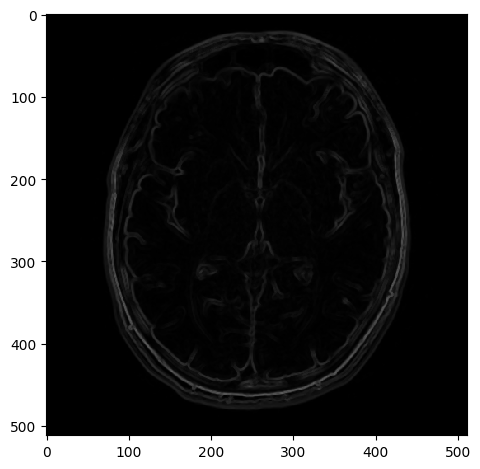

In [27]:
#output_image_path was set as before, output_image_path = output_path + "/final_output.png"
output_image = io.imread(output_image_path)
io.imshow(output_image)